In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd

Calculate gravity of polygon

" Computing the gravitaional and magnetic anomalies due to a polygon: Algorithems and Fortran subroutines' Won 1986


In [146]:
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)

def B(x,z,p1,p2):
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))

def theta(x,z, p):
    if x[p] != 0 :
        if(np.arctan(z[p]/x[p]))<0:
            return(np.arctan(z[p]/x[p])+scipy.pi)
        else:
            return(np.arctan(z[p]/x[p]))
    if x[p] == 0 and z[p]!=0 :
        return(scipy.pi/2)

def r(x,z,p):
    return(np.sqrt(x[p]**2+z[p]**2))

def Z(x,z,p1,p2):
    
    if x[p1] == z[p1]==0 or x[p2] == z[p2]==0:
        return(0)
    
    if x[p1] == x[p2]:
        return((x[p1]*np.log(r(x,z,p2)/r(x,z,p1))))
    
    theta1 = theta(x,z, p1)
    theta2 = theta(x,z, p2)
    
    r1 = r(x,z,p1)
    r2 = r(x,z,p2)
    
    #this is only needed when observation location across z
#     if z[p1]*z[p2]<0:
#         if x[p1]*z[p2]==x[p2]*z[p1]:
#             return(0)
#         if x[p1]*z[p2] < x[p2]*z[p1] and z[p2]>=0:
#             theta1 += 2*scipy.pi
#         if x[p1]*z[p2] > x[p2]*z[p1] and z[p1]>=0:
#             theta2 += 2*scipy.pi
    
    _A = A(x,z,p1,p2)
    _B = B(x,z,p1,p2)
    
    Z_result = _A*((theta1-theta2)+_B*np.log(r1/r2))
    return(Z_result)

Gravity at origin is calculated as $\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}$
(Won, 1987)

In [147]:
def g(data,loc=(0,0)):
    
    G = 6.67 * 10**(-11) # gravitational constant  m^3 kg ^-1 s^-2
    rho = 1000        # density difference   kg/m^3
    
    _data = data - loc #Calculate any point refer to the origin

    _x = _data[:,0]
    _z = _data[:,1]

    Z_sum = 0
    
    for i in range(_data.shape[0]-1):
        Z_sum += Z(_x,_z,i,i+1)

    Z_sum += Z(_x,_z,-1,0)

    g = 2*G*rho * Z_sum
    
    return(g)

In [148]:
def draw(points,ax = None,R = 100):
    if ax == None:
        f,ax=plt.subplots()
    x = points[:,0]
    z = points[:,1]
    for i in range(points.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'r-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
    ax.set_ylim(min(points[:,1])-10,5)
    ax.set_xlim(-R,R)
    
def grav_calculate(points,x=None, R=70,ax = None,style = None):
    if ax is None:
        f,ax=plt.subplots()
    if x is None:
        x = np.linspace(-R,R,501)
    y = np.zeros(np.shape(x))
    obv = np.vstack((x,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(points,i))
    if style is None:
        style = '-'
    ax.plot(x,gravity,style)
    return gravity
    
def plot_true(points,R = None,ax = None):
    if R is None:
        R =max(points[:,0])
    if ax is None:
        f , ax = plt.subplots(2 , sharex = True, figsize = (7,10))
        
    grav_calculate(points, R=max(points[:,0]),ax = ax[0])
    draw(points,ax = ax[1],R=R)
    
    

<b> "note: if z is positive downward and x is positive to the right, then the polygen vertices must be specified clock-wise. " --Won 1987

In [149]:
#define a pseudo boundary condition and corner points
corners=np.array([[-200,-10],# bottom left coner
              [200,-10], 
              [200,-3], # bottom right coner
              [70, -3], # top right coner
              [-70,-3],# top left coner
              [-200,-3]])

In [150]:
corners.shape

(6, 2)

set up the problem

In [151]:
N = 10
points = np.empty((N+6,2))

for i in range(corners.shape[0]-2):
    points[i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(3)

x = np.linspace(-70,70,N+2)

y = np.random.uniform(min(corners[:,1]),max(corners[:,1]),N)

In [152]:
for i in range(N):
    points[i+4][1] = y[i]
for i in range(N):
    points[i+4][0] = x[-i-2]

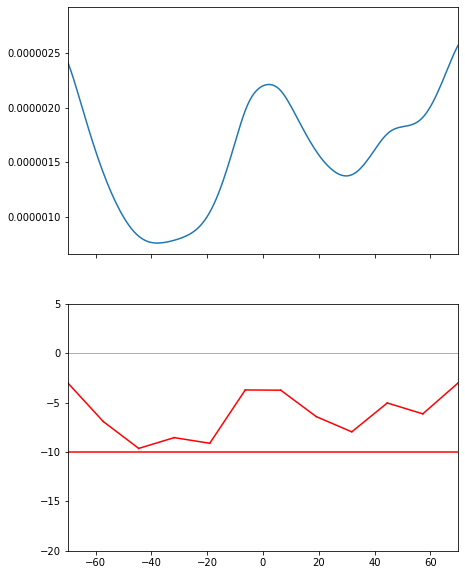

In [153]:
plot_results(points,70)

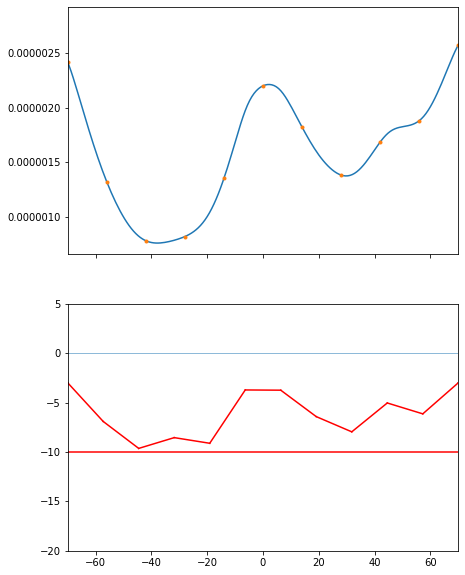

In [154]:
x_obs = np.linspace(-70., 70., 11)
f,ax = plt.subplots(2,sharex = True,figsize = (7,10))
plot_true(points,70,ax)
obv_data = grav_calculate(points,x=x_obs,ax = ax[0],style='.')

In [167]:
noise = norm(0,0.0000001).rvs(len(obv_data))
grav_obs_withnoise = obv_data+noise

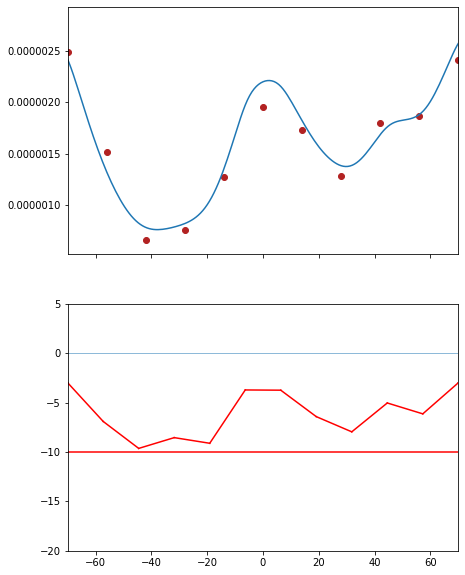

In [173]:
f,ax = plt.subplots(2,sharex = True,figsize = (7,10))
plot_true(points,70,ax)
ax[0].scatter(x_obs,grav_obs_withnoise,color='firebrick')

In [174]:
dtype = tf.float32

In [175]:
obv_data = grav_calculate(points,x=x_obs,ax = ax[0],style='.')

In [ ]:
## initial the model
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

## define the log probability
def joint_log_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))

In [177]:
points

array([[-200.        ,  -10.        ],
       [ 200.        ,  -10.        ],
       [ 200.        ,   -3.        ],
       [  70.        ,   -3.        ],
       [  57.27272727,   -6.14441468],
       [  44.54545455,   -5.04296524],
       [  31.81818182,   -7.96366683],
       [  19.09090909,   -6.42420676],
       [   6.36363636,   -3.74937132],
       [  -6.36363636,   -3.72594838],
       [ -19.09090909,   -9.12090283],
       [ -31.81818182,   -8.54929985],
       [ -44.54545455,   -9.63972958],
       [ -57.27272727,   -6.91433109],
       [ -70.        ,   -3.        ],
       [-200.        ,   -3.        ]])

In [ ]:
x